## Neural Network Classifier-based post-hoc OOD detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import torch.nn as nn

import sys
sys.path.append("../src/models")
from NN import SimpleBinaryClassificationNet

sys.path.append("../src/OODmetrics/")
from nn_posthoc import sample_estimator
from nn_posthoc import GEM_score
from nn_posthoc import make_negpos_logit_array
from nn_posthoc import energy_ood_score

from sklearn.metrics import roc_auc_score
from sklearn.inspection import DecisionBoundaryDisplay

In [2]:
# load
X_train = torch.Tensor(np.load("../data/external/X_train.npy"))
y_train = torch.Tensor(np.load("../data/external/y_train.npy"))
X_test = torch.Tensor(np.load("../data/external/X_test.npy"))
y_test = torch.Tensor(np.load("../data/external/y_test.npy"))

SimpleNet = SimpleBinaryClassificationNet()
path_1 = "../src/models/weight/SimpleNet.pth"
SimpleNet.load_state_dict(torch.load(path_1))

<All keys matched successfully>

In [3]:
SimpleNet

SimpleBinaryClassificationNet(
  (layers1): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
  )
  (layers2): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
  )
  (layers_out): Linear(in_features=16, out_features=1, bias=True)
)

In [4]:
# make grid
feature_1, feature_2 = np.meshgrid(
    np.linspace(X_test[:, 0].detach().numpy().min()-1, X_test[:, 0].detach().numpy().max()+1),
    np.linspace(X_test[:, 1].detach().numpy().min()-1, X_test[:, 1].detach().numpy().max()+1)
)
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T

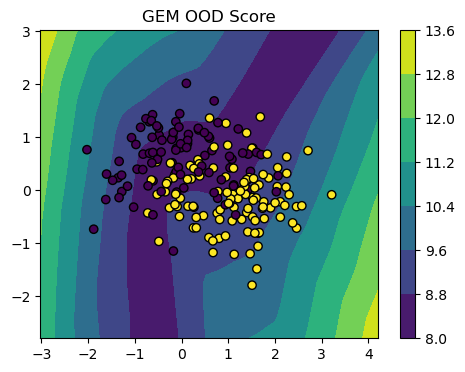

In [5]:
# for GEM score
mu_0,mu_1,precision_matrix = sample_estimator(X_train,y_train,SimpleNet)
grid_GEM_Score_array = GEM_score(SimpleNet,mu_0,mu_1,precision_matrix,torch.tensor(grid).float(),0.5)

fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.set_title("GEM OOD Score")
c_ax1 = ax1.contourf(feature_1,feature_2,np.reshape(grid_GEM_Score_array,feature_1.shape))
ax1.scatter(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),c=y_test,edgecolors="black")
fig.colorbar(c_ax1)

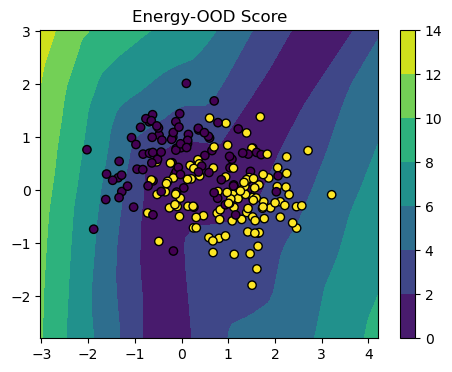

In [6]:
grid_Energy_Score_array = energy_ood_score(SimpleNet,torch.tensor(grid).float(),t=1)

fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.set_title("Energy-OOD Score")
c_ax1 = ax1.contourf(feature_1,feature_2,np.reshape(grid_Energy_Score_array,feature_1.shape))
ax1.scatter(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),c=y_test,edgecolors="black")
fig.colorbar(c_ax1)